
Question 2: Combined Residual Dataset (Sample)

Ticker: AAPL, Month: 1, Residual Vector (first 5 elements): [0.017522135221116505, -0.012444872943215557, -0.0025458900708696906, -0.01568381888321408, 0.005801310353495422]
Ticker: AAPL, Month: 2, Residual Vector (first 5 elements): [-0.009674802898248467, -0.0053893577525279904, 0.012763765541034415, -0.00778875754029593, -0.00036068679916148247]
Ticker: AAPL, Month: 3, Residual Vector (first 5 elements): [0.007414133534766198, -0.002800862423961766, 0.00412472550271991, -0.008331974747291207, 0.013304262611018611]
Ticker: AAPL, Month: 4, Residual Vector (first 5 elements): [-0.005470238825737328, 0.01270784893306707, -0.0031793383281950964, -0.00600911028747759, -0.004730142698303035]
Ticker: AAPL, Month: 5, Residual Vector (first 5 elements): [-0.005805276718223521, 0.0036623689085029127, 0.0024057343609254905, -0.011042994493866386, 0.012083091340479479]
Question 3: Elbow Method for Optimal k



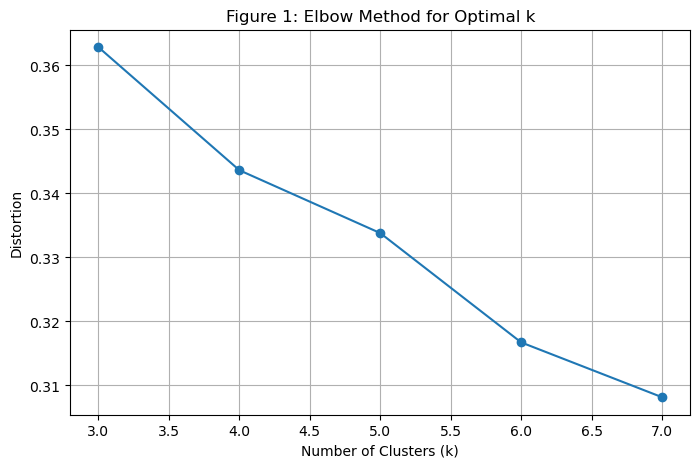

Question 4: Sample Cluster Trajectories

AAPL: [0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
KO: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
DIS: [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0]
JPM: [1, 1, 0, 0, 1, 0, 0, 0, 0, 3, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0]
CVX: [1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 0, 1, 4, 0, 0]

Question 5: Plotting Time-Cluster Trajectories



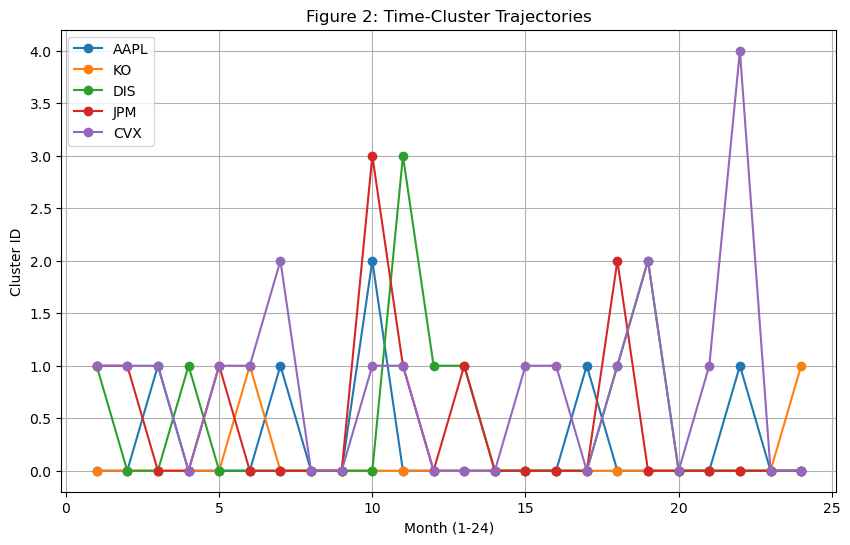


Question 7: Hamming Distances

Answer 6.1: Largest Hamming distance is between ('AAPL', 'CVX') with a distance of 14.00
Answer 6.2: Smallest Hamming distance is between ('AAPL', 'KO') with a distance of 7.00
Answer 6.3: Average Hamming distance is 10.90

Question 8: Longest Time in Same Cluster and Cluster Changes

AAPL - Longest streak in same cluster: 6, Cluster changes: 10
KO - Longest streak in same cluster: 17, Cluster changes: 3
DIS - Longest streak in same cluster: 6, Cluster changes: 9
JPM - Longest streak in same cluster: 6, Cluster changes: 10
CVX - Longest streak in same cluster: 3, Cluster changes: 14


In [36]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming
from itertools import groupby  # Import groupby

import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")


# Question 1
tickers = ["AAPL", "KO", "DIS", "JPM", "CVX", "SPY"]
dataframes = {}

for ticker in tickers:
    data = pd.read_csv(f"{ticker}.csv")
    data['Date'] = pd.to_datetime(data['Date'])
    data = data[(data['Year'] >= 2022) & (data['Year'] <= 2023)]
    dataframes[ticker] = data

# Question 2

residuals = {}

for ticker in tickers[:-1]:  # Exclude SPY
    stock_data = dataframes[ticker]
    spy_data = dataframes["SPY"]
    
    # Merge stock and SPY data by date
    merged = pd.merge(stock_data[['Date', 'Return']], spy_data[['Date', 'Return']], on='Date', suffixes=('', '_SPY'))
    
    # Perform regression
    X = merged[['Return_SPY']].values  # Independent variable (SPY returns)
    y = merged['Return'].values        # Dependent variable (Stock returns)
    reg = LinearRegression().fit(X, y)
    residuals[ticker] = y - reg.predict(X)  # Residuals (εm)

    # Adjust residuals to ensure 20 values per month
    merged['Residual'] = residuals[ticker]
    merged['Month'] = merged['Date'].dt.to_period('M')
    monthly_residuals = merged.groupby('Month')['Residual'].apply(lambda x: list(x[:20]) if len(x) >= 20 else list(x) + [0] * (20 - len(x)))
    residuals[ticker] = monthly_residuals.tolist()


all_residuals = []
for ticker, res in residuals.items():
    for month, vector in enumerate(res):
        all_residuals.append((ticker, month + 1, vector))  # Month index is 1-24

# Print sample output to verify
print("\nQuestion 2: Combined Residual Dataset (Sample)\n")
for i, item in enumerate(all_residuals[:5]):  # Display the first 5 entries
    print(f"Ticker: {item[0]}, Month: {item[1]}, Residual Vector (first 5 elements): {item[2][:5]}")

# Question 3: Perform k-means clustering for k = 3, 4, 5, 6, 7
distortions = []
k_values = range(3, 8)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(residual_vectors)
    distortions.append(kmeans.inertia_)

print("Question 3: Elbow Method for Optimal k\n")
# Plot distortion vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, distortions, marker='o')
plt.title("Figure 1: Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distortion")
plt.grid()
plt.show()

# Choose the best k (manually from the elbow plot)
best_k = 5
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(residual_vectors)

# Question 4: Compute cluster-time trajectories
cluster_trajectories = {ticker: [] for ticker in tickers[:-1]}

for (ticker, month, _), cluster in zip(all_residuals, clusters):
    cluster_trajectories[ticker].append(cluster)

# Verify trajectories
print("Question 4: Sample Cluster Trajectories\n")
for ticker, trajectory in cluster_trajectories.items():
    print(f"{ticker}: {trajectory}")

# Question 5: Plot time-cluster trajectories
print("\nQuestion 5: Plotting Time-Cluster Trajectories\n")
plt.figure(figsize=(10, 6))
for ticker, trajectory in cluster_trajectories.items():
    plt.plot(range(1, 25), trajectory, label=ticker, marker='o')
plt.title("Figure 2: Time-Cluster Trajectories")
plt.xlabel("Month (1-24)")
plt.ylabel("Cluster ID")
plt.legend()
plt.grid()
plt.show()

# Question 7: Compute Hamming distances
hamming_distances = {}

tickers_list = list(cluster_trajectories.keys())
for i, ticker1 in enumerate(tickers_list):
    for j, ticker2 in enumerate(tickers_list):
        if i < j:
            hamming_dist = hamming(cluster_trajectories[ticker1], cluster_trajectories[ticker2]) * 24
            hamming_distances[(ticker1, ticker2)] = hamming_dist

# Identify largest and smallest Hamming distances
max_distance = max(hamming_distances, key=hamming_distances.get)
min_distance = min(hamming_distances, key=hamming_distances.get)
average_distance = np.mean(list(hamming_distances.values()))

print("\nQuestion 7: Hamming Distances\n")
print(f"Answer 6.1: Largest Hamming distance is between {max_distance} with a distance of {hamming_distances[max_distance]:.2f}")
print(f"Answer 6.2: Smallest Hamming distance is between {min_distance} with a distance of {hamming_distances[min_distance]:.2f}")
print(f"Answer 6.3: Average Hamming distance is {average_distance:.2f}")

# Question 7: Longest time in same cluster and number of cluster changes
print("\nQuestion 8: Longest Time in Same Cluster and Cluster Changes\n")
for ticker, trajectory in cluster_trajectories.items():
    # Longest streak in the same cluster
    longest_streak = max(len(list(group)) for key, group in groupby(trajectory))
    
    # Number of cluster changes
    cluster_changes = sum(1 for i in range(len(trajectory) - 1) if trajectory[i] != trajectory[i + 1])
    
    print(f"{ticker} - Longest streak in same cluster: {longest_streak}, Cluster changes: {cluster_changes}")

### Question 9

Summary of the Analysis

Based on the clustering and analysis of stock behavior, the following insights can be drawn:

Cluster Patterns:

Using k-means clustering, we identified distinct clusters representing different residual behaviors of stocks relative to the S&P 500 (SPY).

k=5 was chosen as the optimal number of clusters based on the elbow method, which balances the trade-off between complexity and accuracy.

Cluster-Time Trajectories:

Stocks exhibit varying cluster trajectories over the 24-month period.

Some stocks (e.g., KO) remained relatively stable in their cluster membership, while others (e.g., CVX) experienced frequent cluster transitions, indicating more volatile behavior.

Hamming Distances:

Hamming distances revealed the level of similarity or dissimilarity between stock behaviors:

AAPL and CVX had the largest distance, indicating their behaviors were highly distinct.

AAPL and KO were the most similar, likely reflecting closer alignment in market patterns.

The average Hamming distance across all pairs provided a measure of overall diversity in stock behaviors.

Stock-Specific Insights:

KO (Coca-Cola) was the most stable stock, with the longest streak in the same cluster (17 months) and minimal cluster changes (3 times).

In contrast, CVX (Chevron) exhibited the most dynamic behavior, changing clusters 14 times.

Key Observations:

Stability in cluster membership may indicate consistent market behavior, while frequent transitions reflect sensitivity to external factors or greater volatility.

This analysis provides a quantitative foundation for comparing stocks and identifying those that deviate most significantly from market trends.

Broader Learning:

Residual Analysis: Understanding stock behavior independent of broader market trends (SPY) highlights individual characteristics and performance.

Clustering for Patterns: Clustering revealed meaningful patterns in stock performance, which can inform investment strategies.

Hamming Distance for Similarity: Using Hamming distance, we quantified the similarity of stock behaviors, helping to identify pairs of stocks that align closely or diverge significantly.